# Lab 3: Single Agent with Tool Calling

Build an AI agent using **Microsoft Agent Framework** with tools from **3 different sources**:
- Local Python functions
- Logic Apps (from Lab 2)
- Azure Functions (from Lab 1)

## Learning Objectives

By the end of this lab, you will:
1. Create **local Python functions** as agent tools
2. Add **Logic App** tools for email notifications
3. Add **Azure Function** tools for heavy computation
4. Understand the **data vs reasoning** pattern
5. Build a complete **Graduate Research Assistant**

## Prerequisites

| Requirement | Setup |
|------------|-------|
| Python environment | Run `uv sync --all-extras --dev` from project root |
| Azure CLI logged in | Run `az login` in terminal |
| Azure AI Foundry Project | [Create at ai.azure.com](https://ai.azure.com) |
| Model deployment | Deploy a chat model in your AI Foundry project (see below) |
| Lab 1 (optional) | Azure Function for data analysis |
| Lab 2 (optional) | Logic App for email notifications |

### Model Deployment Options

The `AZURE_AI_MODEL_DEPLOYMENT_NAME` is the **deployment name** of your LLM in Azure AI Foundry. You can use **any chat completion model** you have deployed:

| Model Family | Example Deployment Names | Notes |
|--------------|-------------------------|-------|
| **GPT-4o** | `gpt-4o`, `gpt-4o-mini` | Recommended for most use cases |
| **GPT-4.1** | `gpt-4.1`, `gpt-4.1-mini`, `gpt-4.1-nano` | Newer model with improved capabilities |
| **GPT-4.5** | `gpt-4.5-preview` | Latest preview model |
| **GPT-5** | `gpt-5`, `gpt-5-mini` | If available in your region |
| **Other** | Any deployed model name | Any model supporting tool calling |

> **💡 Tip**: The deployment name is what YOU named it when deploying in AI Foundry, not the model name. Check your [AI Foundry deployments](https://ai.azure.com) to find your deployment name.

## Environment Variables

Create a `.env` file in the project root:

```bash
# Required
AZURE_AI_PROJECT_ENDPOINT=https://your-project.services.ai.azure.com
AZURE_AI_MODEL_DEPLOYMENT_NAME=gpt-4o  # Change to YOUR deployment name!

# Optional (from Lab 1 & 2)
AZURE_FUNCTION_URL=https://your-function.azurewebsites.net/api/analyze_data
AZURE_FUNCTION_KEY=your-function-key
LOGIC_APP_URL=https://prod-xx.eastus.logic.azure.com:443/workflows/...
```

## Architecture

```
┌─────────────────────────────────────────────────────────────────┐
│              Microsoft Agent Framework                          │
│                                                                 │
│   ┌─────────────────────────────────────────────────────────┐   │
│   │              AzureAIAgentsProvider                      │   │
│   │                                                         │   │
│   │   ┌─────────┐           ┌───────────────────────┐       │   │
│   │   │  Agent  │───────────│       4 Tools         │       │   │
│   │   │  (LLM)  │           │                       │       │   │
│   │   └────┬────┘           └───────────┬───────────┘       │   │
│   └────────┼────────────────────────────┼───────────────────┘   │
└────────────┼────────────────────────────┼───────────────────────┘
             │                            │
             │         ┌──────────────────┼──────────────────┐
             │         │                  │                  │
             │    ┌────┴────┐      ┌──────┴──────┐    ┌──────┴──────┐
             │    │  Local  │      │  Logic App  │    │   Azure     │
             │    │Functions│      │   (Lab 2)   │    │  Function   │
             │    │         │      │             │    │   (Lab 1)   │
             │    │ grades  │      │ send_email  │    │analyze_data │
             │    │deadlines│      │             │    │             │
             │    └────┬────┘      └──────┬──────┘    └──────┬──────┘
             │         │                  │                  │
       ┌─────┴─────┐   │                  │                  │
       │  Reasons  │   │                  │                  │
       │  about    │   ▼                  ▼                  ▼
       │  results  │  📊 DB           📧 Email          🔢 Compute
       └───────────┘
```

**Key Concept**: The agent orchestrates tools from different sources:
- **Local functions** — Fast, in-process (database queries)
- **Logic Apps** — Workflow automation (emails, Slack, Teams)
- **Azure Functions** — Serverless compute (heavy processing)


## Step 1: Setup and Imports

In [1]:
import os
import sys
from datetime import datetime, timezone
from pathlib import Path
from typing import Annotated

from dotenv import load_dotenv
from pydantic import Field

# Ensure Azure CLI is in PATH (Homebrew installs to /opt/homebrew/bin on Apple Silicon)
# This is needed because the notebook kernel may not inherit the terminal's PATH
homebrew_paths = ["/opt/homebrew/bin", "/usr/local/bin"]
current_path = os.environ.get("PATH", "")
for p in homebrew_paths:
    if p not in current_path:
        os.environ["PATH"] = p + ":" + current_path
        current_path = os.environ["PATH"]

# Verify az is accessible
import shutil

az_path = shutil.which("az")
if az_path:
    print(f"✅ Azure CLI found: {az_path}")
else:
    print("⚠️  Azure CLI not found. Run: brew install azure-cli && az login")

# Load environment variables from project root
# (notebook runs from notebooks/ folder, .env is in parent)
env_path = Path("../.env")
if env_path.exists():
    load_dotenv(env_path)
    print(f"✅ Loaded .env from {env_path.resolve()}")
else:
    load_dotenv()  # Try current directory
    print("⚠️  No .env found in parent directory, tried current directory")

# Verify required env vars
required_vars = ["AZURE_AI_PROJECT_ENDPOINT", "AZURE_AI_MODEL_DEPLOYMENT_NAME"]
missing = [v for v in required_vars if not os.getenv(v)]
if missing:
    print(f"❌ Missing environment variables: {missing}")
    print("   Please create a .env file in the project root with:")
    print("   AZURE_AI_PROJECT_ENDPOINT=https://your-project.services.ai.azure.com")
    print("   AZURE_AI_MODEL_DEPLOYMENT_NAME=gpt-4o")
else:
    print("✅ Environment configured")
    print(f"   Project: {os.getenv('AZURE_AI_PROJECT_ENDPOINT')[:50]}...")
    print(f"   Model: {os.getenv('AZURE_AI_MODEL_DEPLOYMENT_NAME')}")

✅ Azure CLI found: /opt/homebrew/bin/az
✅ Loaded .env from /Users/pablo/Desktop/githubRepos/teaching/northwestern/northwestern-fy26-msai-foundry-agentic-ai/.env
✅ Environment configured
   Project: https://test-foundry-env-pablosal.services.ai.azur...
   Model: gpt-4.1



## Step 2: Simulated Databases + Local Function Tools

In a real application, the agent would query actual databases. Here we simulate:
- **GRADES_DB** — Student grades by course (assignment name, score, max, weight)
- **DEADLINES_DB** — Upcoming assignments (name, due date, priority)

The agent uses **two tools** that query these databases:

In [2]:
# ============================================================
# SIMULATED DATABASES
# In production, these would be real database queries
# ============================================================

# Grade database: course -> list of (assignment_name, score, max_score, weight)
GRADES_DB = {
    "CS 101": [
        ("Problem Set 1", 92, 100, 0.10),
        ("Problem Set 2", 85, 100, 0.10),
        ("Problem Set 3", 78, 100, 0.10),
        ("Midterm Exam", 88, 100, 0.25),
        ("Problem Set 4", 95, 100, 0.10),
        ("Quiz 1", 90, 100, 0.05),
        ("Quiz 2", 82, 100, 0.05),
        # Final not yet graded
    ],
    "STAT 302": [
        ("Homework 1", 95, 100, 0.08),
        ("Homework 2", 88, 100, 0.08),
        ("Homework 3", 92, 100, 0.08),
        ("Lab Report 1", 85, 100, 0.12),
        ("Midterm", 79, 100, 0.25),
        ("Homework 4", 90, 100, 0.08),
    ],
    "ML 450": [
        ("Assignment 1: Linear Regression", 98, 100, 0.15),
        ("Assignment 2: Classification", 94, 100, 0.15),
        ("Paper Review 1", 88, 100, 0.10),
        ("Midterm Project", 91, 100, 0.20),
    ],
}

# Deadline database: course -> list of (assignment_name, due_date, priority)
DEADLINES_DB = {
    "CS 101": [
        ("Problem Set 5", "2026-01-25", "High"),
        ("Midterm Exam", "2026-02-01", "Critical"),
        ("Final Project Proposal", "2026-02-15", "Medium"),
    ],
    "STAT 302": [
        ("Regression Analysis Report", "2026-01-28", "High"),
        ("Lab Report 2", "2026-02-05", "Medium"),
        ("Final Project Proposal", "2026-02-10", "Medium"),
    ],
    "ML 450": [
        ("Neural Network Lab", "2026-01-23", "Critical"),
        ("Paper Review 2", "2026-01-30", "Medium"),
        ("Final Project", "2026-02-20", "High"),
    ],
}

print("📚 Simulated Databases Loaded:")
print(f"   GRADES_DB: {len(GRADES_DB)} courses")
print(f"   DEADLINES_DB: {len(DEADLINES_DB)} courses")
for course in GRADES_DB:
    print(
        f"     • {course}: {len(GRADES_DB[course])} grades, {len(DEADLINES_DB.get(course, []))} deadlines"
    )

📚 Simulated Databases Loaded:
   GRADES_DB: 3 courses
   DEADLINES_DB: 3 courses
     • CS 101: 7 grades, 3 deadlines
     • STAT 302: 6 grades, 3 deadlines
     • ML 450: 4 grades, 3 deadlines


### Define the Two Local Tools

These tools query the simulated databases and let the LLM reason about the data.

In [3]:
# ============================================================
# TOOL 1: Analyze Grades
# ============================================================


def analyze_grades(
    course: Annotated[
        str, Field(description="Course name to analyze (e.g., 'CS 101', 'STAT 302', 'ML 450')")
    ],
) -> str:
    """
    Query the grade database for a course and return detailed grade analysis.
    Returns all assignment scores, calculated statistics, and current standing.
    """
    # Find the course in database
    course_key = None
    for key in GRADES_DB:
        if course.upper() in key.upper():
            course_key = key
            break

    if not course_key:
        available = ", ".join(GRADES_DB.keys())
        return f"❌ Course '{course}' not found. Available courses: {available}"

    grades = GRADES_DB[course_key]

    # Build detailed output
    result = f"📊 Grade Report for {course_key}\n"
    result += "=" * 50 + "\n\n"

    # List all assignments
    result += "📝 Assignments Completed:\n"
    scores = []
    weighted_sum = 0
    total_weight = 0

    for name, score, max_score, weight in grades:
        pct = (score / max_score) * 100
        scores.append(pct)
        weighted_sum += pct * weight
        total_weight += weight

        # Grade indicator
        indicator = "✅" if pct >= 90 else "📗" if pct >= 80 else "📙" if pct >= 70 else "📕"
        result += f"  {indicator} {name}: {score}/{max_score} ({pct:.1f}%) [weight: {weight * 100:.0f}%]\n"

    # Calculate statistics
    n = len(scores)
    mean = sum(scores) / n
    sorted_scores = sorted(scores)
    median = (
        sorted_scores[n // 2] if n % 2 else (sorted_scores[n // 2 - 1] + sorted_scores[n // 2]) / 2
    )
    variance = sum((s - mean) ** 2 for s in scores) / n
    std_dev = variance**0.5

    # Current weighted grade
    current_grade = weighted_sum / total_weight if total_weight > 0 else 0
    letter = (
        "A"
        if current_grade >= 90
        else "B"
        if current_grade >= 80
        else "C"
        if current_grade >= 70
        else "D"
        if current_grade >= 60
        else "F"
    )

    result += f"\n📈 Statistics:\n"
    result += f"  • Assignments graded: {n}\n"
    result += f"  • Average score: {mean:.1f}%\n"
    result += f"  • Median score: {median:.1f}%\n"
    result += f"  • Std deviation: {std_dev:.1f}%\n"
    result += f"  • Lowest: {min(scores):.1f}% | Highest: {max(scores):.1f}%\n"

    result += f"\n🎯 Current Standing:\n"
    result += f"  • Weighted grade: {current_grade:.1f}% ({letter})\n"
    result += f"  • Weight completed: {total_weight * 100:.0f}% of course\n"

    # Trend analysis
    if n >= 3:
        recent_avg = sum(scores[-3:]) / 3
        early_avg = sum(scores[:3]) / 3
        trend = (
            "📈 Improving"
            if recent_avg > early_avg + 2
            else "📉 Declining"
            if recent_avg < early_avg - 2
            else "➡️ Stable"
        )
        result += f"  • Trend: {trend}\n"

    return result


# ============================================================
# TOOL 2: Check Deadlines
# ============================================================


def check_deadlines(
    course: Annotated[
        str, Field(description="Course name to check deadlines for (e.g., 'CS 101', 'all')")
    ],
) -> str:
    """
    Query the deadline database and return upcoming assignments with due dates.
    Use 'all' to see deadlines across all courses.
    """
    today = datetime(2026, 1, 21)  # Current date for the simulation

    if course.lower() == "all":
        result = "📅 All Upcoming Deadlines\n"
        result += "=" * 50 + "\n\n"

        # Collect all deadlines with course info
        all_deadlines = []
        for c, items in DEADLINES_DB.items():
            for name, date_str, priority in items:
                due_date = datetime.strptime(date_str, "%Y-%m-%d")
                days_until = (due_date - today).days
                all_deadlines.append((c, name, date_str, priority, days_until))

        # Sort by days until due
        all_deadlines.sort(key=lambda x: x[4])

        for c, name, date_str, priority, days_until in all_deadlines:
            emoji = "🔴" if priority == "Critical" else "🟡" if priority == "High" else "🟢"
            urgency = (
                "⚠️ OVERDUE!"
                if days_until < 0
                else f"⏰ TODAY!"
                if days_until == 0
                else f"📆 {days_until} days"
            )
            result += f"{emoji} [{c}] {name}\n"
            result += f"   Due: {date_str} ({urgency})\n"
            result += f"   Priority: {priority}\n\n"

        return result

    # Find specific course
    course_key = None
    for key in DEADLINES_DB:
        if course.upper() in key.upper():
            course_key = key
            break

    if not course_key:
        available = ", ".join(DEADLINES_DB.keys())
        return f"❌ Course '{course}' not found. Available courses: {available}"

    deadlines = DEADLINES_DB[course_key]

    result = f"📅 Deadlines for {course_key}\n"
    result += "=" * 50 + "\n\n"

    for name, date_str, priority in deadlines:
        due_date = datetime.strptime(date_str, "%Y-%m-%d")
        days_until = (due_date - today).days

        emoji = "🔴" if priority == "Critical" else "🟡" if priority == "High" else "🟢"
        urgency = (
            "⚠️ OVERDUE!"
            if days_until < 0
            else f"⏰ TODAY!"
            if days_until == 0
            else f"📆 {days_until} days left"
        )

        result += f"{emoji} {name}\n"
        result += f"   Due: {date_str} ({urgency})\n"
        result += f"   Priority: {priority}\n\n"

    return result


print("✅ Local tools defined:")
print("   • analyze_grades(course) — Query grade database, return scores & statistics")
print("   • check_deadlines(course) — Query deadline database, return due dates")

✅ Local tools defined:
   • analyze_grades(course) — Query grade database, return scores & statistics
   • check_deadlines(course) — Query deadline database, return due dates


## Step 3: Create Agent with AzureAIAgentsProvider

The `AzureAIAgentsProvider` is the recommended way to create agents with Azure AI Foundry.

**Key Methods:**
- `create_agent()` — Create a new agent on the service
- `get_agent()` — Retrieve an existing agent by ID
- `as_agent()` — Wrap an SDK agent without HTTP calls

In [4]:
from agent_framework.azure import AzureAIAgentsProvider
from azure.identity.aio import DefaultAzureCredential


async def run_basic_agent():
    """Create and run a Graduate Research Assistant with database tools."""

    # DefaultAzureCredential tries multiple auth methods:
    # 1. Environment variables (AZURE_CLIENT_ID, AZURE_TENANT_ID, AZURE_CLIENT_SECRET)
    # 2. Managed Identity (if running in Azure)
    # 3. Azure CLI (az login)
    # 4. VS Code Azure extension
    # 5. Interactive browser login

    async with (
        DefaultAzureCredential() as credential,
        AzureAIAgentsProvider(credential=credential) as provider,
    ):
        # Create agent with the two database tools
        agent = await provider.create_agent(
            name="GradResearchAssistantCoolbot",
            instructions="""You are a Graduate Research Assistant AI helping students manage their academic work.

You have access to two tools that query the student's academic databases:

1. analyze_grades(course) — Query the grade database for a specific course
   Returns: All assignment scores, statistics, current weighted grade, trends
   
2. check_deadlines(course) — Query the deadline database  
   Use 'all' to see all courses, or specify a course name
   Returns: Upcoming assignments with due dates and priority levels

When a student asks about their academic performance:
- Query the relevant databases using your tools
- Analyze the data and provide helpful insights
- If you notice concerning patterns (low grades, urgent deadlines), proactively mention them
- Be encouraging but honest about areas needing improvement""",
            tools=[analyze_grades, check_deadlines],
        )

        print(f"✅ Agent created: {agent.name}")
        print(f"   ID: {agent.id}")
        print(f"   Tools: analyze_grades, check_deadlines\n")

        # Test queries
        queries = [
            "What are my grades in CS 101?",
            "Check all my upcoming deadlines",
            "How am I doing in STAT 302? Any deadlines I should worry about?",
        ]

        for query in queries:
            print("=" * 60)
            print(f"📤 Student: {query}")
            print("-" * 60)
            result = await agent.run(query)
            print(f"🤖 Assistant:\n{result}")
            print()


# Run the agent
await run_basic_agent()

✅ Agent created: GradResearchAssistantCoolbot
   ID: asst_F7htz2NqoMx2i2XjvRQaedrL
   Tools: analyze_grades, check_deadlines

📤 Student: What are my grades in CS 101?
------------------------------------------------------------
🤖 Assistant:
Here’s your CS 101 grade breakdown:

- Current weighted grade: 87.5% (B)
- Assignments graded: 7 (average score: 87.1%)
- Highest score: 95.0% (Problem Set 4)
- Lowest score: 78.0% (Problem Set 3)

Your grade trend is improving, with recent assignments showing higher scores. Keep up the strong effort! If you consistently perform at this level, you're on track for a solid finish. Let me know if you want tips on tackling specific assignments or exams.

📤 Student: Check all my upcoming deadlines
------------------------------------------------------------
🤖 Assistant:
Here are all your upcoming deadlines across your courses:

- ML 450: Neural Network Lab (Critical) – Due in 2 days
- CS 101: Problem Set 5 (High) – Due in 4 days
- STAT 302: Regression An

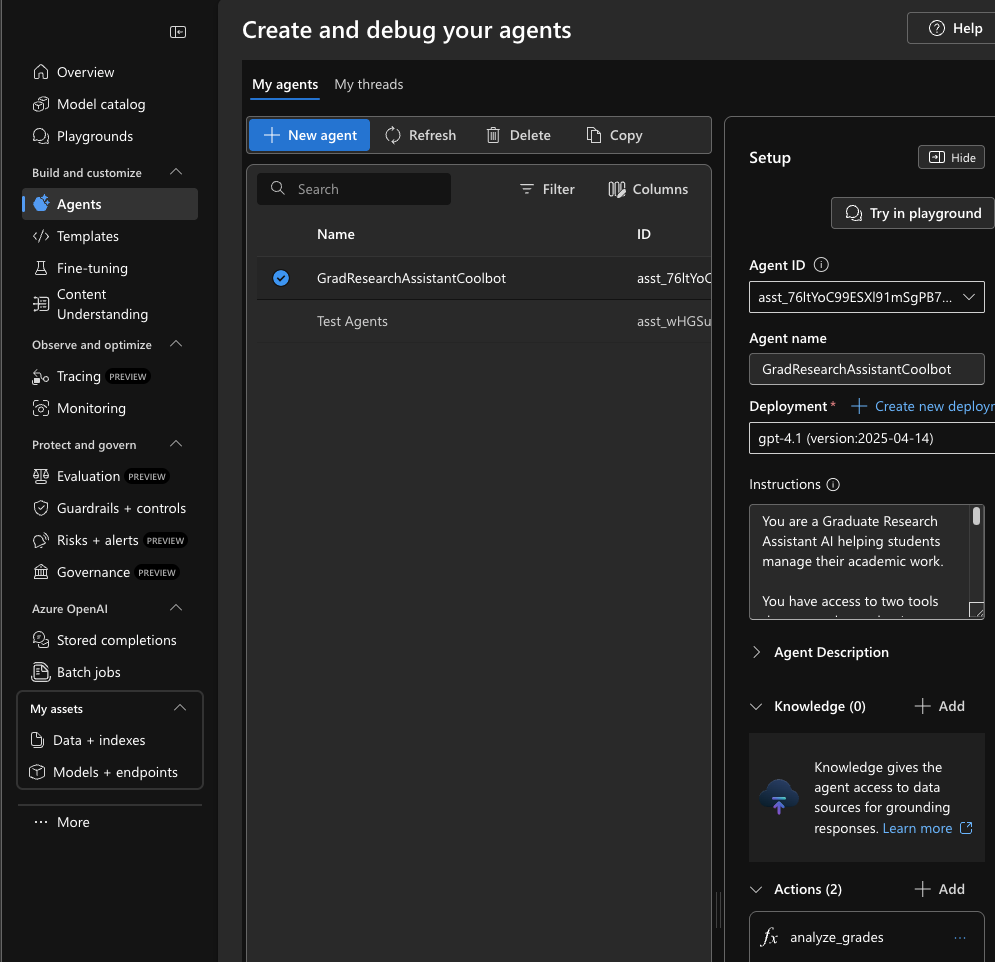

## Step 4: Add Logic App Tool (Email Notifications)

Now let's add a **Logic App** tool that the agent can use to send email notifications.
This connects to the workflow you built in **Lab 2**.

**Use Cases:**
- Send deadline reminders to students
- Email grade reports
- Alert when grades drop below a threshold

In [9]:
import aiohttp

# ============================================================
# TOOL 3: Send Email via Logic App (from Lab 2)
# ============================================================


def create_email_tool(logic_app_url: str):
    """Create a tool that sends emails via Logic App workflow."""

    async def send_email(
        to: Annotated[str, Field(description="Recipient email address")],
        subject: Annotated[str, Field(description="Email subject line")],
        message: Annotated[str, Field(description="Email body content")],
    ) -> str:
        """Send an email notification using Logic App workflow."""
        try:
            async with aiohttp.ClientSession() as session:
                async with session.post(
                    logic_app_url,
                    headers={"Content-Type": "application/json"},
                    json={"to": to, "subject": subject, "message": message},
                    timeout=aiohttp.ClientTimeout(total=30),
                ) as response:
                    if response.status in [200, 202]:
                        return f"✅ Email sent successfully!\n   To: {to}\n   Subject: {subject}"
                    else:
                        return f"❌ Email failed: HTTP {response.status}"
        except Exception as e:
            return f"❌ Email error: {str(e)}"

    return send_email


# Check if Logic App is configured (from Lab 2)
logic_app_url = os.getenv("LOGIC_APP_URL")

if logic_app_url:
    send_email = create_email_tool(logic_app_url)
    print("✅ Logic App configured - send_email tool ready")
    print(f"   URL: {logic_app_url[:50]}...")
else:
    # Mock function for demo when Logic App not configured
    async def send_email(
        to: Annotated[str, Field(description="Recipient email address")],
        subject: Annotated[str, Field(description="Email subject line")],
        message: Annotated[str, Field(description="Email body content")],
    ) -> str:
        """Send an email notification (mock - simulates Logic App)."""
        return f"""📧 Email Sent (Mock - Logic App not configured)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
To: {to}
Subject: {subject}
Message: {message}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Status: ✓ Delivered (simulated)

💡 To use real emails, set LOGIC_APP_URL from Lab 2"""

    print("⚠️  LOGIC_APP_URL not set - using mock send_email")
    print("   Set LOGIC_APP_URL from Lab 2 to send real emails")

✅ Logic App configured - send_email tool ready
   URL: https://prod-13.northcentralus.logic.azure.com:443...




## Step 6: Complete Graduate Research Assistant

Now let's create the full agent with all **4 tools** and test a complex multi-step query.

In [ ]:
async def run_complete_assistant():
    """Create the complete Graduate Research Assistant with all 4 tools."""

    async with (
        DefaultAzureCredential() as credential,
        AzureAIAgentsProvider(credential=credential) as provider,
    ):
        agent = await provider.create_agent(
            name="GradResearchAssistant",
            instructions="""You are a Graduate Research Assistant AI helping students succeed.
            
Your capabilities (4 tools):
📊 analyze_grades(course) — Query grade database for a specific course
📅 check_deadlines(course) — Query deadline database (use 'all' for all courses)
📧 send_email(to, subject, message) — Send email notifications via Logic App
🔢 analyze_data(values) — Statistical analysis via Azure Function

When helping students:
1. Query databases to understand their situation
2. If they need analysis, use the Azure Function for computation
3. If they want reminders or notifications, use the email tool
4. Be proactive about identifying concerns and suggesting solutions""",
            tools=[
                analyze_grades,  # Local - query grade DB
                check_deadlines,  # Local - query deadline DB
                send_email,  # Logic App - notifications
            ],
        )

        print(f"✅ Complete Research Assistant ready with 4 tools\n")

        # Complex multi-step query that uses multiple tools
        complex_query = """
        I'm preparing for finals. Can you:
        1. Check all my upcoming deadlines
        2. Show me how I'm doing in ML 450
        3. Run a statistical analysis on my ML 450 scores
        4. Send me an email summary to `your_email_here`
        """

        print("=" * 70)
        print("📤 Student Query:")
        print(complex_query)
        print("=" * 70)

        result = await agent.run(complex_query)
        print("\n🤖 Research Assistant Response:")
        print(result)


# Run the complete assistant
await run_complete_assistant()

✅ Complete Research Assistant ready with 4 tools

📤 Student Query:

        I'm preparing for finals. Can you:
        1. Check all my upcoming deadlines
        2. Show me how I'm doing in ML 450
        3. Run a statistical analysis on my ML 450 scores
        4. Send me an email summary to pablosal@microsoft.com
        

🤖 Research Assistant Response:
Here's your finals preparation summary:

1. Upcoming Deadlines (next 30 days):
   - ML 450: Neural Network Lab – due 2026-01-23 (2 days) [Critical]
   - CS 101: Problem Set 5 – due 2026-01-25 (4 days) [High]
   - STAT 302: Regression Analysis Report – due 2026-01-28 (7 days) [High]
   - ML 450: Paper Review 2 – due 2026-01-30 (9 days) [Medium]
   - CS 101: Midterm Exam – due 2026-02-01 (11 days) [Critical]
   - STAT 302: Lab Report 2 – due 2026-02-05 (15 days) [Medium]
   - STAT 302: Final Project Proposal – due 2026-02-10 (20 days) [Medium]
   - CS 101: Final Project Proposal – due 2026-02-15 (25 days) [Medium]
   - ML 450: Final Pro

## Step 8: Interactive Chat Session

Chat with your agent using all 4 tools!

In [11]:
async def interactive_research_session():
    """Run an interactive session with all 4 tools."""

    async with (
        DefaultAzureCredential() as credential,
        AzureAIAgentsProvider(credential=credential) as provider,
    ):
        agent = await provider.create_agent(
            name="GradAssistant",
            instructions="""You are a helpful Graduate Research Assistant with 4 tools:
- analyze_grades: Query grade database
- check_deadlines: Query deadline database  
- send_email: Send email notifications

Help students with their academic needs.""",
            tools=[analyze_grades, check_deadlines, send_email],
        )

        # Get a new thread for conversation history
        thread = agent.get_new_thread()

        print("🎓 Graduate Research Assistant Ready!")
        print("=" * 60)
        print("Available tools:")
        print("  📊 Grades     — 'How am I doing in CS 101?'")
        print("  📅 Deadlines  — 'Check my deadlines'")
        print("  📧 Email      — 'Email me a summary'")
        print("  🔢 Analysis   — 'Analyze these scores: 85,90,78,92'")
        print()
        print("Courses in database: CS 101, STAT 302, ML 450")
        print("Type 'quit' to exit")
        print("=" * 60)

        while True:
            try:
                user_input = input("\n📝 You: ").strip()
            except EOFError:
                break

            if not user_input:
                continue
            if user_input.lower() in ["quit", "exit", "q"]:
                print("\n👋 Goodbye! Good luck with your studies!")
                break

            print("\n⏳ Thinking...")
            # Pass the thread to agent.run() to maintain conversation history
            response = await agent.run(user_input, thread=thread)
            print(f"\n🤖 Assistant: {response}")


# Run interactive session
await interactive_research_session()

🎓 Graduate Research Assistant Ready!
Available tools:
  📊 Grades     — 'How am I doing in CS 101?'
  📅 Deadlines  — 'Check my deadlines'
  📧 Email      — 'Email me a summary'
  🔢 Analysis   — 'Analyze these scores: 85,90,78,92'

Courses in database: CS 101, STAT 302, ML 450
Type 'quit' to exit

👋 Goodbye! Good luck with your studies!


## Step 9: Gradio Chat Interface 🎨

Launch your UI (frontend)..

In [12]:
import gradio as gr
import nest_asyncio
from agent_framework.azure import AzureAIAgentsProvider
from azure.identity.aio import DefaultAzureCredential

# Enable nested event loops for Jupyter
nest_asyncio.apply()


# Global state for the agent session
class AgentSession:
    def __init__(self):
        self.agent = None
        self.thread = None
        self.provider = None
        self.credential = None
        self.initialized = False

    async def initialize(self):
        if not self.initialized:
            self.credential = DefaultAzureCredential()
            self.provider = AzureAIAgentsProvider(credential=self.credential)
            await self.provider.__aenter__()

            self.agent = await self.provider.create_agent(
                name="GradResearchAssistant",
                instructions="""You are a Graduate Research Assistant AI helping students succeed.

Your capabilities (3 tools):
📊 analyze_grades(course) — Query grade database for a specific course
📅 check_deadlines(course) — Query deadline database (use 'all' for all courses)
📧 send_email(to, subject, message) — Send email notifications

Available courses: CS 101, STAT 302, ML 450

When helping students:
1. Query databases to understand their situation
2. If they want reminders or notifications, use the email tool
3. Be proactive about identifying concerns and suggesting solutions
4. Be encouraging but honest about areas needing improvement""",
                tools=[analyze_grades, check_deadlines, send_email],
            )
            self.thread = self.agent.get_new_thread()
            self.initialized = True
            print("✅ Agent initialized!")

    async def chat(self, message: str) -> str:
        """Process chat message with the agent."""
        try:
            await self.initialize()
            response = await self.agent.run(message, thread=self.thread)
            return str(response)
        except Exception as e:
            import traceback

            traceback.print_exc()
            return f"❌ Error: {str(e)}"

    def reset(self):
        """Reset the session for a new conversation."""
        self.thread = self.agent.get_new_thread() if self.agent else None


# Create session
session = AgentSession()


# Gradio response function using messages format (Gradio 5.x default)
async def respond(message: str, history: list):
    """Async handler for Gradio chat."""
    if not message.strip():
        return history, ""

    # Get response from agent
    bot_message = await session.chat(message)

    # Gradio 5.x expects list of dicts with role/content keys
    history.append({"role": "user", "content": message})
    history.append({"role": "assistant", "content": bot_message})
    return history, ""


# Build Gradio interface
with gr.Blocks(title="Graduate Research Assistant") as demo:
    gr.Markdown("""
    # 🎓 Graduate Research Assistant
    
    Chat with your AI assistant that has access to your academic data!
    
    **Available Tools:**
    - 📊 **Grades** — "How am I doing in CS 101?"
    - 📅 **Deadlines** — "Check all my deadlines"
    - 📧 **Email** — "Send me a summary at student@northwestern.edu"
    
    **Courses:** CS 101, STAT 302, ML 450
    """)

    chatbot = gr.Chatbot(
        height=400,
        placeholder="Ask about your grades, deadlines, or request email notifications...",
    )

    msg = gr.Textbox(
        placeholder="Type your message here... (e.g., 'What are my grades in ML 450?')",
        label="Your Message",
        lines=2,
    )

    with gr.Row():
        submit = gr.Button("Send 📤", variant="primary")
        clear = gr.Button("Clear 🗑️")

    gr.Examples(
        examples=[
            "What are my grades in CS 101?",
            "Check all my upcoming deadlines",
            "How am I doing in STAT 302? Any urgent deadlines?",
            "Send a deadline reminder to student@northwestern.edu",
        ],
        inputs=msg,
    )

    # Event handlers
    msg.submit(respond, [msg, chatbot], [chatbot, msg])
    submit.click(respond, [msg, chatbot], [chatbot, msg])
    clear.click(lambda: [], outputs=[chatbot])

# Launch
print("🚀 Launching Gradio interface...")
demo.launch(share=False, height=700)

🚀 Launching Gradio interface...
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


✅ Agent initialized!


## Summary

In this lab, you learned how to build an AI agent with **4 tools from 3 different sources**:

### Tool Architecture

| Tool | Source | Lab | Purpose |
|------|--------|-----|---------|
| `analyze_grades` | Local Function | — | Query grade database |
| `check_deadlines` | Local Function | — | Query deadline database |
| `send_email` | Logic App | Lab 2 | Email notifications |
| `analyze_data` | Azure Function | Lab 1 | Statistical computation |

### Key Patterns Learned

**1. Local Functions** — Fast, in-process tools
```python
def my_tool(param: Annotated[str, Field(description="...")]) -> str:
    return DATABASE[param]
```

**2. Logic App Tools** — Workflow automation
```python
async def send_email(to, subject, message) -> str:
    async with aiohttp.ClientSession() as session:
        await session.post(LOGIC_APP_URL, json={...})
```

**3. Azure Function Tools** — Serverless compute
```python
async def analyze_data(values) -> str:
    async with aiohttp.ClientSession() as session:
        await session.post(FUNCTION_URL, json={"values": [...]})
```

### When to Use Each Tool Type

| Tool Type | Best For |
|-----------|----------|
| **Local** | Database queries, formatting, fast operations |
| **Logic App** | Emails, Slack, Teams, calendar, workflows |
| **Azure Function** | Heavy computation, ML inference, data processing |


**Congratulations!** You've built a Graduate Research Assistant that combines local functions, Logic Apps, and Azure Functions using Microsoft Agent Framework!